# Diffusion Model from Scratch (MNIST Dataset)
Based on https://arxiv.org/abs/2006.11239

In [38]:
import math
import torch
import torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Beta schedule & Helper functions

In [39]:
def make_beta_schedule(T=1000, beta_start=1e-4, beta_end=2e-2, device='cpu'):
  betas = torch.linspace(beta_start, beta_end, T, device=device)
  alphas = 1.0 - betas
  alphas_bar = torch.cumprod(alphas, dim=0)
  return betas, alphas, alphas_bar

# Sinusoidal timestep embedding (like Transformers)
def timestep_embedding(t: torch.Tensor, dim: int):
  half = dim // 2
  freqs = torch.exp(-math.log(10000) * torch.arange(0, half, device=t.device).float() / half)
  args = t.float()[:, None] * freqs[None]
  emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
  if dim % 2 == 1:  # pad if odd
      emb = F.pad(emb, (0,1))
  return emb

# Classic DDPM forward process
def full_forward_process(x0, t, sqrt_ab, sqrt_one_minus_ab):
  eps = torch.randn_like(x0)
  s1 = sqrt_ab[t].view(-1, 1, 1, 1)
  s2 = sqrt_one_minus_ab[t].view(-1, 1, 1, 1)
  xt = s1 * x0 + s2 * eps
  return xt, eps

## TinyUNet Architecture
- Encoder: Extract features & Downsampling
- Bottleneck: Compressed/Extracted features
- Decoder: Upsampling & Skip connections -> Reconstruct details
- Output: ε̂ same dimension as input

In [40]:
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, t_dim):
        super().__init__()
        self.norm1 = nn.GroupNorm(8, in_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.time = nn.Linear(t_dim, out_ch)
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = F.silu(self.norm1(x))
        h = self.conv1(h)
        # add time embedding
        h = h + self.time(t_emb)[:, :, None, None]
        h = F.silu(self.norm2(h))
        h = self.conv2(h)
        return h + self.skip(x)

class TinyUNet(nn.Module):
    def __init__(self, img_ch=1, base=64, t_dim=128):
        super().__init__()
        self.t_proj = nn.Sequential(
            nn.Linear(t_dim, t_dim*4), nn.SiLU(), nn.Linear(t_dim*4, t_dim)
        )

        # encoder
        self.in_conv = nn.Conv2d(img_ch, base, 3, padding=1)
        self.rb1 = ResBlock(base, base, t_dim)
        self.down = nn.Conv2d(base, base*2, 4, stride=2, padding=1)   # 28->14
        self.rb2 = ResBlock(base*2, base*2, t_dim)

        # bottleneck
        self.mid = ResBlock(base*2, base*2, t_dim)

        # decoder
        self.up = nn.ConvTranspose2d(base*2, base, 4, stride=2, padding=1)       # 14->28
        self.rb3 = ResBlock(base*2, base, t_dim)  # skip concat
        self.out = nn.Conv2d(base, img_ch, 1)

    def forward(self, x, t):
        t_emb = timestep_embedding(t, 128)
        t_emb = self.t_proj(t_emb)

        h0 = self.in_conv(x)
        h1 = self.rb1(h0, t_emb)
        h2 = self.down(h1)
        h3 = self.rb2(h2, t_emb)

        m = self.mid(h3, t_emb)

        u = self.up(m)
        u = torch.cat([u, h1], dim=1)  # simple skip from early layer
        u = self.rb3(u, t_emb)

        return self.out(u)  # predict epsilon

## Setup & Data

In [41]:
T = 1000
betas, alphas, alphas_bar = make_beta_schedule(T=T, device=device)
tfm = transforms.Compose([
    transforms.ToTensor(),  # [0, 1]
])

model = TinyUNet(img_ch=1, base=64, t_dim=128).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)

Example data

Batch shape: torch.Size([8, 1, 28, 28])
Some example labels: tensor([1, 7, 3, 2, 6, 7, 6, 6]) 



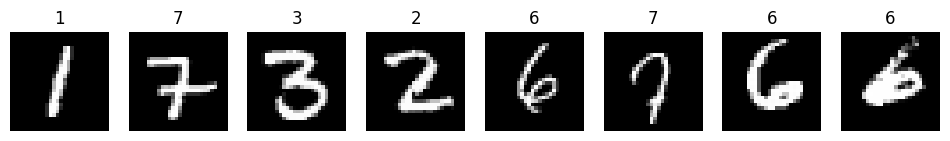

In [59]:
mnist_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=tfm)
dataloader = DataLoader(mnist_dataset, batch_size=128, shuffle=True, num_workers=2, drop_last=True)

# Plot example data from DataLoader
n_show = 8
x, y = next(iter(dataloader))

x = x[:n_show]
y = y

print("Batch shape:", x.shape)
print("Some example labels:", y[:n_show], "\n")

fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i in range(8):
  axes[i].imshow(x[i, 0].numpy(), cmap="gray")
  axes[i].set_title(str(y[i].item()))
  axes[i].axis("off")
plt.show()

## Training

In [43]:
def train_one_epoch(model, loader, optimizer, alphas_bar, device):
  model.train()
  sqrt_ab = torch.sqrt(alphas_bar)
  sqrt_1mab = torch.sqrt(1 - alphas_bar)
  T = alphas_bar.shape[0]

  total_loss = 0.0

  for x, _ in loader:
    x = x.to(device) * 2 - 1 # Rescale [0,1] -> [-1,1]
    batch_size = x.size(0)
    t = torch.randint(0, T, (batch_size,), device=device) # Model learns about all timesteps equally (statistically)
    xt, eps = full_forward_process(x, t, sqrt_ab, sqrt_1mab)
    eps_hat = model(xt, t)
    loss = F.mse_loss(eps_hat, eps)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item() * batch_size
  return total_loss / len(loader.dataset)

Start Training

In [44]:
num_epochs = 50
for epoch in range(num_epochs):
  loss = train_one_epoch(model, dataloader, optimizer, alphas_bar, device)
  print(f"Epoch {epoch+1}: Loss={loss:.4f}")

Epoch 1: Loss=0.0641
Epoch 2: Loss=0.0324
Epoch 3: Loss=0.0296
Epoch 4: Loss=0.0282
Epoch 5: Loss=0.0273
Epoch 6: Loss=0.0263
Epoch 7: Loss=0.0260
Epoch 8: Loss=0.0258
Epoch 9: Loss=0.0255
Epoch 10: Loss=0.0252
Epoch 11: Loss=0.0250
Epoch 12: Loss=0.0250
Epoch 13: Loss=0.0242
Epoch 14: Loss=0.0244
Epoch 15: Loss=0.0243
Epoch 16: Loss=0.0243
Epoch 17: Loss=0.0241
Epoch 18: Loss=0.0242
Epoch 19: Loss=0.0240
Epoch 20: Loss=0.0236
Epoch 21: Loss=0.0238
Epoch 22: Loss=0.0237
Epoch 23: Loss=0.0233
Epoch 24: Loss=0.0235
Epoch 25: Loss=0.0233
Epoch 26: Loss=0.0234
Epoch 27: Loss=0.0233
Epoch 28: Loss=0.0233
Epoch 29: Loss=0.0233
Epoch 30: Loss=0.0232
Epoch 31: Loss=0.0229
Epoch 32: Loss=0.0229
Epoch 33: Loss=0.0228
Epoch 34: Loss=0.0232
Epoch 35: Loss=0.0230
Epoch 36: Loss=0.0228
Epoch 37: Loss=0.0228
Epoch 38: Loss=0.0227
Epoch 39: Loss=0.0228
Epoch 40: Loss=0.0229
Epoch 41: Loss=0.0227
Epoch 42: Loss=0.0227
Epoch 43: Loss=0.0226
Epoch 44: Loss=0.0227
Epoch 45: Loss=0.0227
Epoch 46: Loss=0.02

## Testing & Sampling

In [47]:
@torch.no_grad()
def sample_demo(model, betas, alphas, alphas_bar, device="cpu", step=50):
  model.eval()
  T = alphas.shape[0]
  t_start = T-1
  batch_size = 16

  snaps = []
  t_snaps = []
  t_snaps_set = set(range(t_start, -1, -step))
  t_snaps_set.add(0)

  sqrt_ab = torch.sqrt(alphas_bar)
  sqrt_1mab = torch.sqrt(1 - alphas_bar)

  # Start from Noise
  x = torch.randn(16, 1, 28, 28, device=device)

  # Reverse Process
  for t in range(t_start, -1, -1):
    t_batch = torch.full((batch_size,), t, device=device, dtype=torch.long)
    eps_hat = model(x, t_batch)

    current = (x - (betas[t] / torch.sqrt(1 - alphas_bar[t])) * eps_hat) / torch.sqrt(alphas[t])
    if t > 0:
      x = current + torch.sqrt(betas[t]) * torch.randn_like(x)
    else:
      x = current

    if t in t_snaps_set:
      snap = x.detach().clone()
      snap = torch.clamp((snap + 1) / 2, 0, 1)
      snaps.append(snap)
      t_snaps.append(t)

  return snaps, t_snaps


Generated samples:



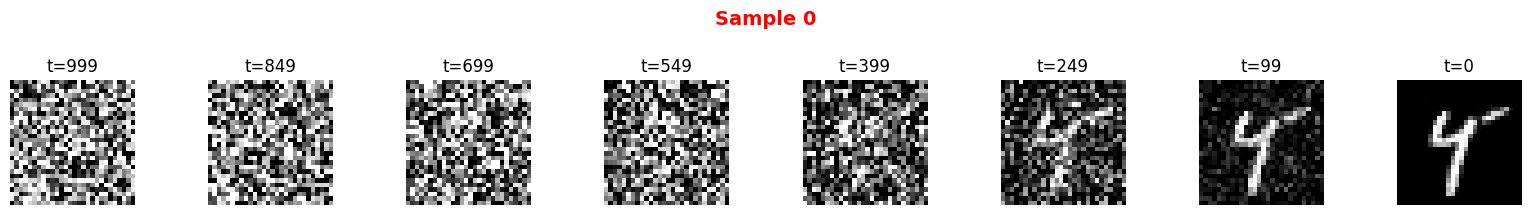

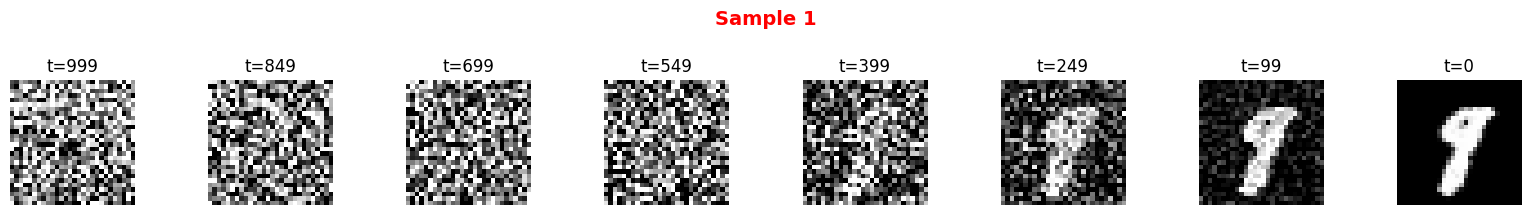

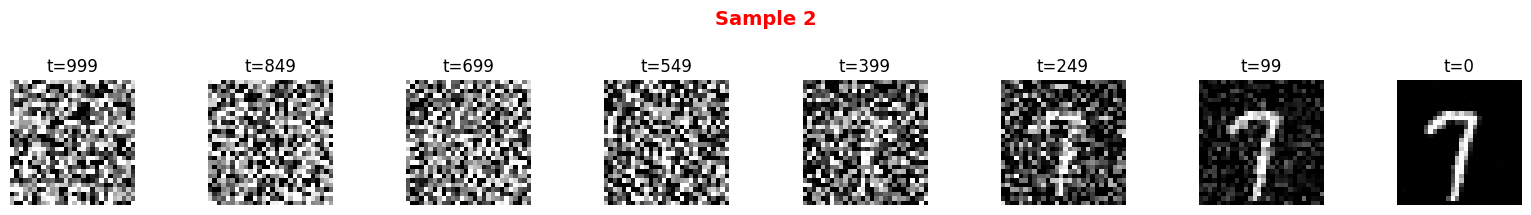

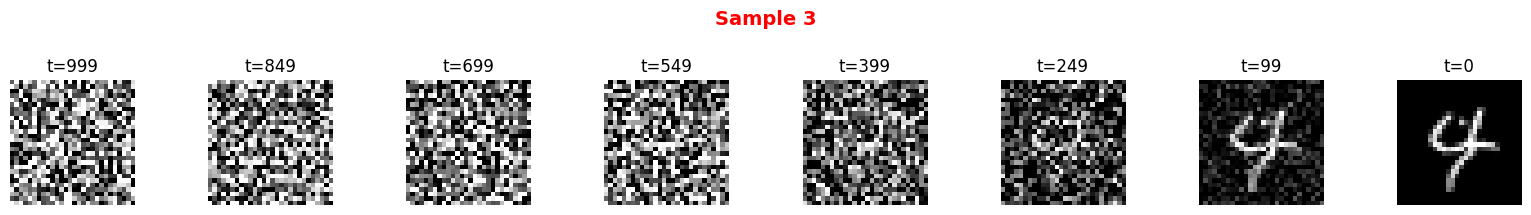

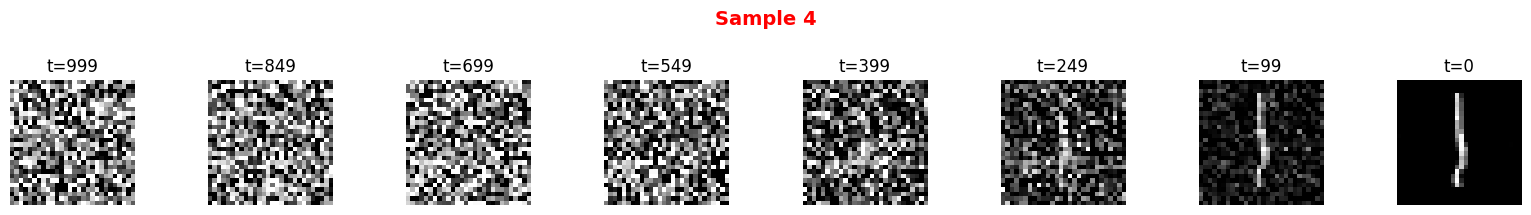

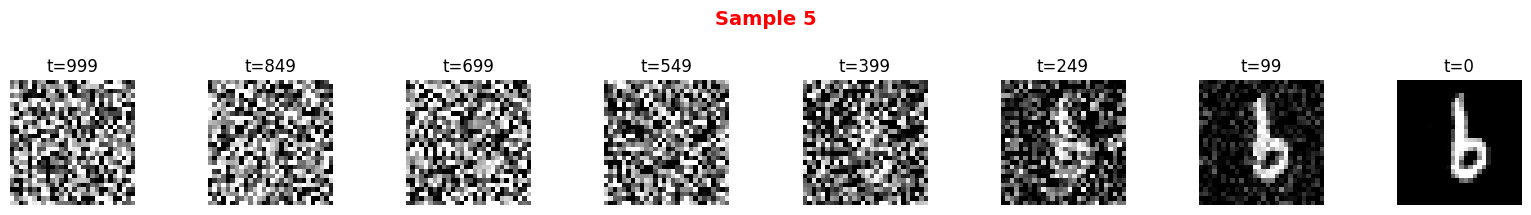

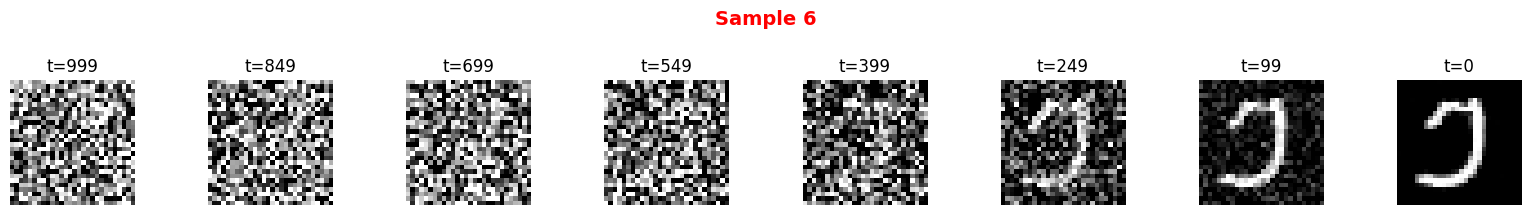

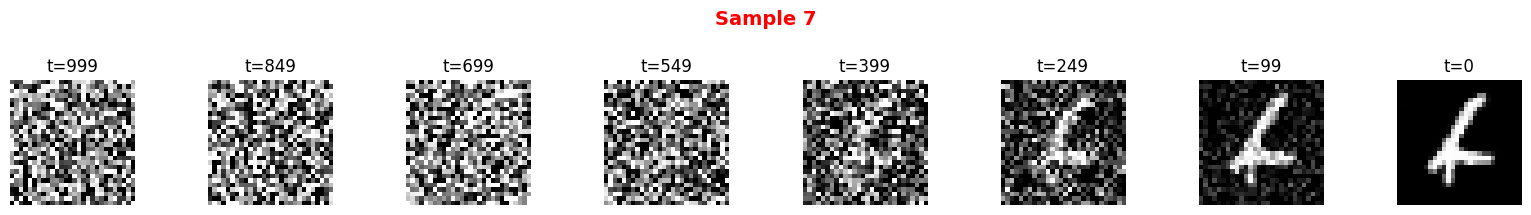

In [57]:
snaps, ts = sample_demo(model, betas, alphas, alphas_bar, device=device, step=150)

print("\nGenerated samples:\n")

for i in range(n_show):
    fig, axs = plt.subplots(1, len(snaps), figsize=(2*len(snaps), 2))

    for j, (img, t) in enumerate(zip(snaps, ts)):
        axs[j].imshow(img[i,0].cpu().numpy(), cmap="gray")
        axs[j].set_title(f"t={t}")
        axs[j].axis("off")

    fig.suptitle(f"Sample {i}", fontsize=14, weight="bold", color="red", y=1.05)

    plt.tight_layout()
    plt.show()